# Analyzing download speeds in Kentucky counties using Python

In this tutorial I will talk about how to:

    * Download the Ookla open dataset
    * Geocode the tiles to Kentucky counties
    * Make a table of the top and bottom 20 counties by download speed
    * Map the counties

There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This tutorial will use the spatial join approach.

In [1]:
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text
from pyathena import connect

#### Get data from athena

In [2]:
import time
import boto3
import pandas as pd
import io

class QueryAthena:

    def __init__(self, query, database):
        self.database = database
        self.folder = 'athena-output/'
        self.bucket = 'uiuc-research-paper'
        self.s3_output =  's3://' + self.bucket + '/' + self.folder
        self.region_name = 'us-east-2'
        self.query = query

    def load_conf(self, q):
        try:
            self.client = boto3.client('athena', 
                              region_name = self.region_name)
            response = self.client.start_query_execution(
                QueryString = q,
                    QueryExecutionContext={
                    'Database': self.database
                    },
                    ResultConfiguration={
                    'OutputLocation': self.s3_output,
                    }
            )
            self.filename = response['QueryExecutionId']
            print('Execution ID: ' + response['QueryExecutionId'])

        except Exception as e:
            print(e)
        return response                

    def run_query(self):
        queries = [self.query]
        for q in queries:
            res = self.load_conf(q)
        try:              
            query_status = None
            while query_status == 'QUEUED' or query_status == 'RUNNING' or query_status is None:
                query_status = self.client.get_query_execution(QueryExecutionId=res["QueryExecutionId"])['QueryExecution']['Status']['State']
                print(query_status)
                if query_status == 'FAILED' or query_status == 'CANCELLED':
                    raise Exception('Athena query with the string "{}" failed or was cancelled'.format(self.query))
                time.sleep(10)
            print('Query "{}" finished.'.format(self.query))

            df = self.obtain_data()
            return df

        except Exception as e:
            print(e)      

    def obtain_data(self):
        try:
            self.resource = boto3.resource('s3', 
                                  region_name = self.region_name)

            response = self.resource \
            .Bucket(self.bucket) \
            .Object(key= self.folder + self.filename + '.csv') \
            .get()

            return pd.read_csv(io.BytesIO(response['Body'].read()), encoding='utf8')   
        except Exception as e:
            print(e)  

In [3]:
query = "SELECT * FROM kentucky_download_speed"
qa = QueryAthena(query=query, database='ookla')
qa.filename = 'dc356a07-a4d0-4c0e-9928-78cc5003f7a1'
tiles_in_ky_counties = qa.obtain_data()

In [4]:
# convert to Mbps for easier reading
tiles_in_ky_counties['avg_d_mbps'] = tiles_in_ky_counties['avg_d_kbps'] / 1000
tiles_in_ky_counties['avg_u_mbps'] = tiles_in_ky_counties['avg_u_kbps'] / 1000

In [5]:
tiles_in_ky_counties.head()

,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,quadkey,tile,statefp,countyfp,countyns,...,cbsafp,metdivfp,funcstat,aland,awater,intptlat,intptlon,geometry,avg_d_mbps,avg_u_mbps
0,231958,11843,35,1,1,320003031311320,"POLYGON((-85.80322265625 38.1086276643213, -85...",21,111,516902,...,31140.0,NaN,C,986032282,43964666,38.189532,-85.657624,POLYGON ((-85.8426419999999979 38.233595000000...,231.958,11.843
1,480273,16742,47,1,1,320003202112211,"POLYGON((-86.9073486328125 37.3876174997839, -...",21,183,516938,...,NaN,NaN,A,1521059918,23162111,37.477859,-86.844871,POLYGON ((-87.0766869999999926 37.515799000000...,480.273,16.742
2,9756,13175,26,2,1,320003120103032,"POLYGON((-85.550537109375 38.2252352390768, -8...",21,111,516902,...,31140.0,NaN,C,986032282,43964666,38.189532,-85.657624,POLYGON ((-85.8426419999999979 38.233595000000...,9.756,13.175
3,20812,4139,15,2,1,320012302030121,"POLYGON((-82.8533935546875 37.3614255019052, -...",21,119,516906,...,NaN,NaN,A,910427588,3453304,37.354368,-82.952546,POLYGON ((-83.0926539999999960 37.498848999999...,20.812,4.139
4,33980,2462,22,1,1,320003312320020,"POLYGON((-84.90234375 37.2215804583865, -84.89...",21,45,516869,...,NaN,NaN,A,1150572403,3891526,37.321962,-84.928219,POLYGON ((-85.0445019999999943 37.419115999999...,33.980,2.462


---

## Make a table of the top 20 and bottom 20 counties

Next we can make a summary table of just the best and worst counties by download speed. We’ll require that counties have at least 50 tests so that the averages are more reliable.

In [6]:
# def weighted_mean(group, avg_name, weight_name):
#     """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
#     In rare instance, we may not have weights, so just return the mean. Customize this if your business case
#     should return otherwise.
#     """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return d.mean()
    
county_stats = (
    tiles_in_ky_counties.groupby(["geoid", "namelsad"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_ky_counties.groupby(["geoid", "namelsad"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["geoid", "namelsad"],
    )
)

In [7]:
county_stats.head()

,geoid,namelsad,avg_d_mbps_wt,tests
0,21001,Adair County,49.471302,1027
1,21003,Allen County,105.509080,1067
2,21005,Anderson County,116.799375,1850
3,21007,Ballard County,44.127718,561
4,21009,Barren County,82.018677,4037


In [8]:
SAMPLE_TAKEN = 20


table_stats = (
    county_stats.loc[county_stats["tests"] >= 50]
    .nlargest(SAMPLE_TAKEN, "avg_d_mbps_wt")
    .append(
        county_stats.loc[county_stats["tests"] >= 50].nsmallest(SAMPLE_TAKEN, "avg_d_mbps_wt")
    )
    .sort_values("avg_d_mbps_wt", ascending=False)
    .round(2) # round to 2 decimal places for easier reading
)

In [9]:
header = ["GEOID", "County", "Avg download speed (Mbps)", "Tests"]

table_stats.rename(columns=dict(zip(table_stats.columns, header)))

,GEOID,County,Avg download speed (Mbps),Tests
110,21223,Trimble County,161.65,407
33,21067,Fayette County,157.85,45628
55,21111,Jefferson County,154.51,60149
58,21117,Kenton County,154.23,12664
7,21015,Boone County,152.47,14329
40,21081,Grant County,152.10,1424
23,21047,Christian County,148.64,4872
18,21037,Campbell County,147.29,7445
38,21077,Gallatin County,146.59,551
103,21209,Scott County,142.16,4973


---

## Map the counties
The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick choropleth map that will help give a more visual representation.

We can join our county statistics table to the basemap (remember, we already got rid of the geometry from that county statistics table). I’m also creating a categorical variable from the continuous download speed because people aren’t great at reading continuous color schemes. People can read discrete legends much more easily, with 7 categories maximum (this can depend on the situation, though).

One thing that helps people orient themselves on a map is including major place names. The census FTP site makes it fairly easy to get a quick list!

In [10]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

In [11]:
county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
counties = gp.read_file(county_url)
# filter out the Kentucky fips code and reproject to match the tiles
ky_counties = counties.loc[counties['STATEFP'] == '21'].to_crs(4326)
ky_counties['geoid'] = ky_counties['GEOID'].astype(int)

In [12]:
ky_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,geoid
9,21,053,00516873,21053,Clinton,Clinton County,06,H1,G4020,None,None,None,A,510875755,21152699,+36.7272577,-085.1360977,"POLYGON ((-85.23910 36.76983, -85.23443 36.786...",21053
58,21,003,00516848,21003,Allen,Allen County,06,H1,G4020,150,14540,None,A,891838779,19482100,+36.7507703,-086.1924580,"POLYGON ((-86.29580 36.85107, -86.29347 36.852...",21003
66,21,231,00516962,21231,Wayne,Wayne County,06,H1,G4020,None,None,None,A,1186690748,67283816,+36.8007715,-084.8265896,"POLYGON ((-85.04450 36.87093, -85.03908 36.874...",21231
133,21,209,00516951,21209,Scott,Scott County,06,H1,G4020,336,30460,None,A,729774435,9440820,+38.2857099,-084.5783405,"POLYGON ((-84.58054 38.47304, -84.58010 38.473...",21209
157,21,061,00516877,21061,Edmonson,Edmonson County,06,H1,G4020,150,14540,None,A,784468358,13258105,+37.2275136,-086.2180153,"POLYGON ((-86.39916 37.16990, -86.39932 37.170...",21061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,21,011,00516852,21011,Bath,Bath County,06,H1,G4020,336,34460,None,A,722081430,13486211,+38.1522485,-083.7376405,"POLYGON ((-83.87589 38.13174, -83.87598 38.131...",21011
3160,21,181,00516937,21181,Nicholas,Nicholas County,06,H1,G4020,None,None,None,A,505465731,4302198,+38.3380310,-084.0262231,"POLYGON ((-84.13728 38.31174, -84.13764 38.312...",21181
3184,21,019,00516856,21019,Boyd,Boyd County,06,H1,G4020,170,26580,None,A,414054164,5581073,+38.3600037,-082.6814063,"POLYGON ((-82.77254 38.36332, -82.77261 38.363...",21019
3210,21,115,00516904,21115,Johnson,Johnson County,06,H1,G4020,None,None,None,A,678485015,5623156,+37.8477561,-082.8301215,"POLYGON ((-82.98598 37.82649, -82.98629 37.826...",21115


In [13]:
county_data = ky_counties[['geoid', 'geometry']].merge(county_stats, on='geoid').to_crs(26916)

In [14]:
county_data

,geoid,geometry,namelsad,avg_d_mbps_wt,tests
0,21053,"POLYGON ((657155.675 4070785.004, 657538.965 4...",Clinton County,53.100753,822
1,21003,"POLYGON ((562779.292 4078583.116, 562985.625 4...",Allen County,105.509080,1067
2,21231,"POLYGON ((674295.990 4082339.981, 674771.268 4...",Wayne County,32.797299,2778
3,21209,"POLYGON ((711064.785 4261075.241, 711101.701 4...",Scott County,142.156189,4973
4,21061,"POLYGON ((553341.023 4113888.738, 553326.765 4...",Edmonson County,46.927272,1153
...,...,...,...,...,...
114,21011,"POLYGON ((773829.197 4225043.925, 773821.285 4...",Bath County,51.222680,575
115,21181,"POLYGON ((750295.881 4244282.698, 750262.682 4...",Nicholas County,67.389718,209
116,21019,"POLYGON ((869398.405 4254593.636, 869391.889 4...",Boyd County,83.617733,3411
117,21115,"POLYGON ((853321.054 4194161.634, 853293.090 4...",Johnson County,98.880921,3780


In [15]:
labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

county_data['group'] = pd.cut(
    county_data.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

In [16]:
# add place labels 
ky_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_21_place.zip")

In [17]:
ky_places = ky_places.loc[ky_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
ky_places["centroid"] = ky_places["geometry"].centroid
ky_places.set_geometry("centroid", inplace = True)

Legend


1

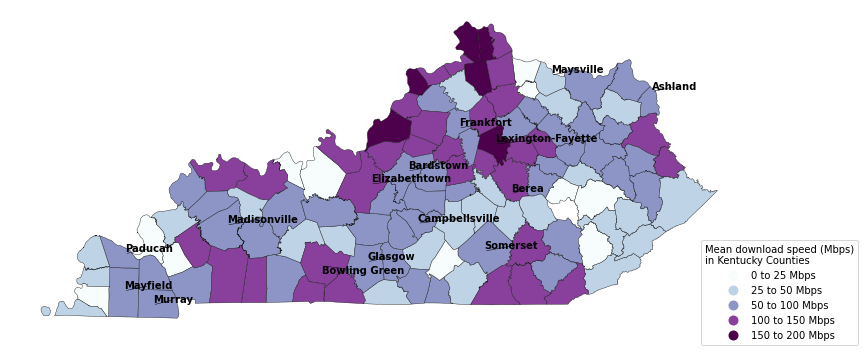

In [18]:
fig, ax = plt.subplots(1, figsize=(16, 6))

county_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")
leg = ax.get_legend()
print(leg)
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title("Mean download speed (Mbps)\nin Kentucky Counties")

texts = []
for x, y, label in zip(ky_places.geometry.x, ky_places.geometry.y, ky_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

adjust_text(
    texts,
    force_points=0.3,
    force_text=0.8,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)